In [1]:
input_patch_size = [500,500] # input patch (expect output to be smaller)
input_channels = [3] # RGB
output_channels = [2] #cell and bkg

trained_models_path = '../trained_models'

print('Avaible models:\n')
!ls ../trained_models/*.h5
print('\nchoose model name (no extension)')
NAME_NET = raw_input()
if 'MIMO' in NAME_NET:
    MIMO = True
    UNET = False
if 'UNET' in NAME_NET:
    MIMO = False
    UNET = True

if output_channels[0] == 3:
    train_y_path = "train_yc"
    eval_y_path = "eval_yc"
if output_channels[0] == 2:
    train_y_path = "train_y"
    eval_y_path = "eval_y"
    

Avaible models:

../trained_models/MIMO_1.h5
../trained_models/MIMO_270.h5
../trained_models/MIMO_270_c1.h5
../trained_models/MIMO_300_c1.h5
../trained_models/MIMO_300_c3.h5
../trained_models/MIMO_500_AdaDelta_c2.h5
../trained_models/MIMO_500_adadeldta_c2.h5
../trained_models/MIMO_500_c1.h5
../trained_models/MIMO_500_c2.h5
../trained_models/MIMO_Test1_1Class.h5
../trained_models/MIMO_exp1.h5
../trained_models/UNET_500_c3.h5
../trained_models/UNET_EB4QCASF.h5

choose model name (no extension)
MIMO_500_AdaDelta_c2


In [2]:
import keras
import sys
import matplotlib
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
import os

sys.path.append('../')

from datasets import CD_Dataset
from models import Unet, MimoNet
from utility import show_batches, from_categorical, train, crop_receptive, predict_full_image
from utility import dice, precision, Pc
from datasets import combine_y_w

seed = int((time.time()*1e6)%1e6)
np.random.seed(seed)
keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=seed)

NAME_NET = os.path.join(trained_models_path,NAME_NET)

Using TensorFlow backend.


In [3]:
# Load the dataset
dataset_path = '../CD_Dataset'
dataset = CD_Dataset( path=dataset_path, 
                     train_y_path=train_y_path,  
                     eval_y_path=eval_y_path, 
                     fit=True, download=True, 
                     num_classes=output_channels[0] )

In [4]:
# define your model
model_input_size = input_patch_size + input_channels
if UNET:
    print('UNET')
    model = Unet(model_input_size, classes=output_channels[0])
if MIMO:
    print('MIMO')
    model = MimoNet(model_input_size, classes=output_channels[0])
model_inputs_size = list(model.inputs_shape[0])
model_outputs_size = list(model.outputs_shape[0])
print("input size: {}\noutput size: {}".format(model_inputs_size,model_outputs_size))

MIMO
input size: [500, 500, 3]
output size: [332, 332, 2]


In [5]:
# Load model
print(NAME_NET)
model.load_model(NAME_NET)
train_histo = np.load(NAME_NET+'_train_histo.pkl')
eval_histo = np.load(NAME_NET+'_eval_histo.pkl')


../trained_models/MIMO_500_AdaDelta_c2


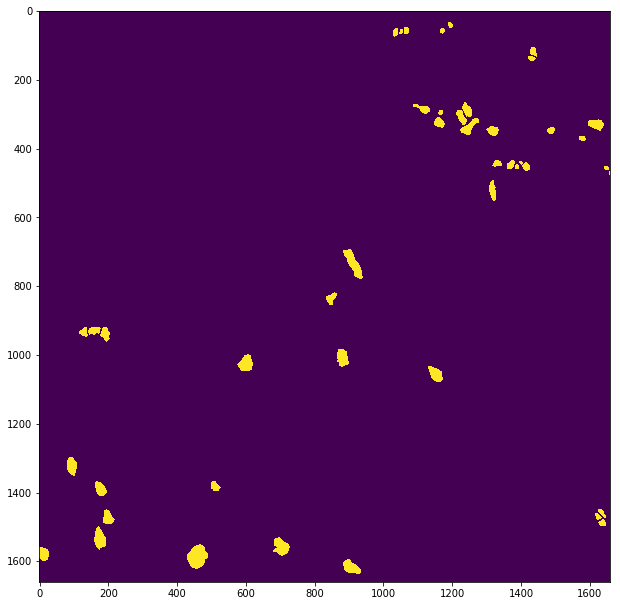

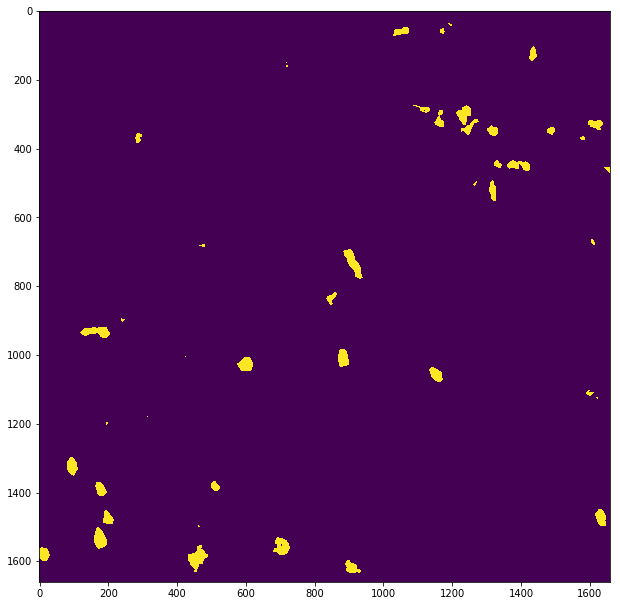

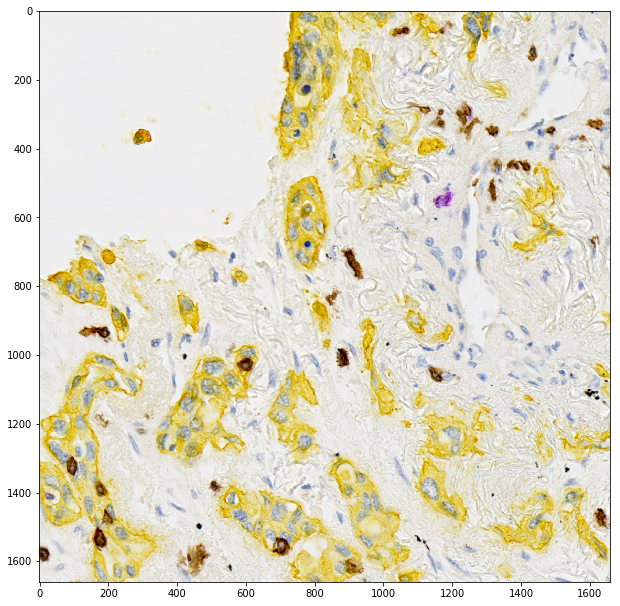

[['dice', 0.87768647281921619], ['Precision', 0.85103029595470203], ['Pc', 0.87054137244251317]]


In [7]:
# Show results
means = dataset.mean_features()
stds = dataset.std_features()

X,Y,W = dataset.get_X_Y_W(index=2,train=False)
Y_hat,crops = predict_full_image(model,X)
cropsh,cropsw = crops

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5,forward=True)

Yimg = from_categorical(np.expand_dims(Y,0))[0]

plt.imshow(Yimg[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]])
plt.show()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5,forward=True)
plt.imshow(Y_hat[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]])
plt.show()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10.5, 10.5,forward=True)
plt.imshow(X[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]]*stds+means)
plt.show()

dice_s = dice(Yimg[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]],Y_hat[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]])
precision_s = precision(Yimg[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]],Y_hat[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]])
Pc_s = Pc(Yimg[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]],Y_hat[cropsh[0]:cropsh[1],cropsw[0]:cropsw[1]])

table = [["dice",dice_s],
         ["Precision",precision_s],
         ["Pc",Pc_s]]
print(table)